In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser

In [2]:
# halo simulation
z_h     =  0.2425
log_m   =  14.745
M_200   =  10.**(log_m)
conc    =  4.
halo    =  hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)

In [ ]:
# Reconstruction Init
configName  =   'config_darkmapper.ini'
parser      =   ConfigParser()
parser.read(configName)

parser.set('sparse','mu','3e-4')
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %halo.rs)  #Mpc/h
parser.set('sparse','nframe','1' )

In [4]:
# Grid for pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False) 
# if deltaIn it is lensing kernel from density contrast to shear

CS02    =   hmod.nfwCS02_grid(parser)
data2   =   CS02.add_halo(halo)[1]
# I give an arbitary error map. It doesnot matter since our data is
# noiseless
gErr    =   np.ones(Grid.shape)*0.05

dmapper =   darkmapper(parser,data2.real,data2.imag,gErr,lensKer1)

dmapper.lbd=8. # for lasso
dmapper.lcd=0. # for elastic net
dmapper.nonNeg=True
dmapper.clean_outcomes()
dmapper.mu=3e-3
dmapper.fista_gradient_descent(3000)
w   =   dmapper.adaptive_lasso_weight(gamma=2.)
dmapper.fista_gradient_descent(3000,w=w)

for _ in range(3):
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent(3000,w=w)
dmapper.reconstruct()
c1  =   detect.local_maxima_3D(dmapper.deltaR)[0][0]
# checking the position
np.testing.assert_equal(c1,np.array([4,Grid.ny//2,Grid.nx//2]))
logm_est=   np.log10((dmapper.alphaR*dmapper._w)[4,0,Grid.ny//2,Grid.nx//2])+14.
# checking the mass estimation
np.testing.assert_almost_equal(logm_est,log_m,1)

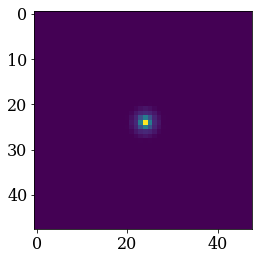

In [12]:
plt.imshow(dmapper.deltaR[4])